In [ ]:
!pip install -q transformers

In [ ]:
from transformers import pipeline

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection",device = 'cuda')

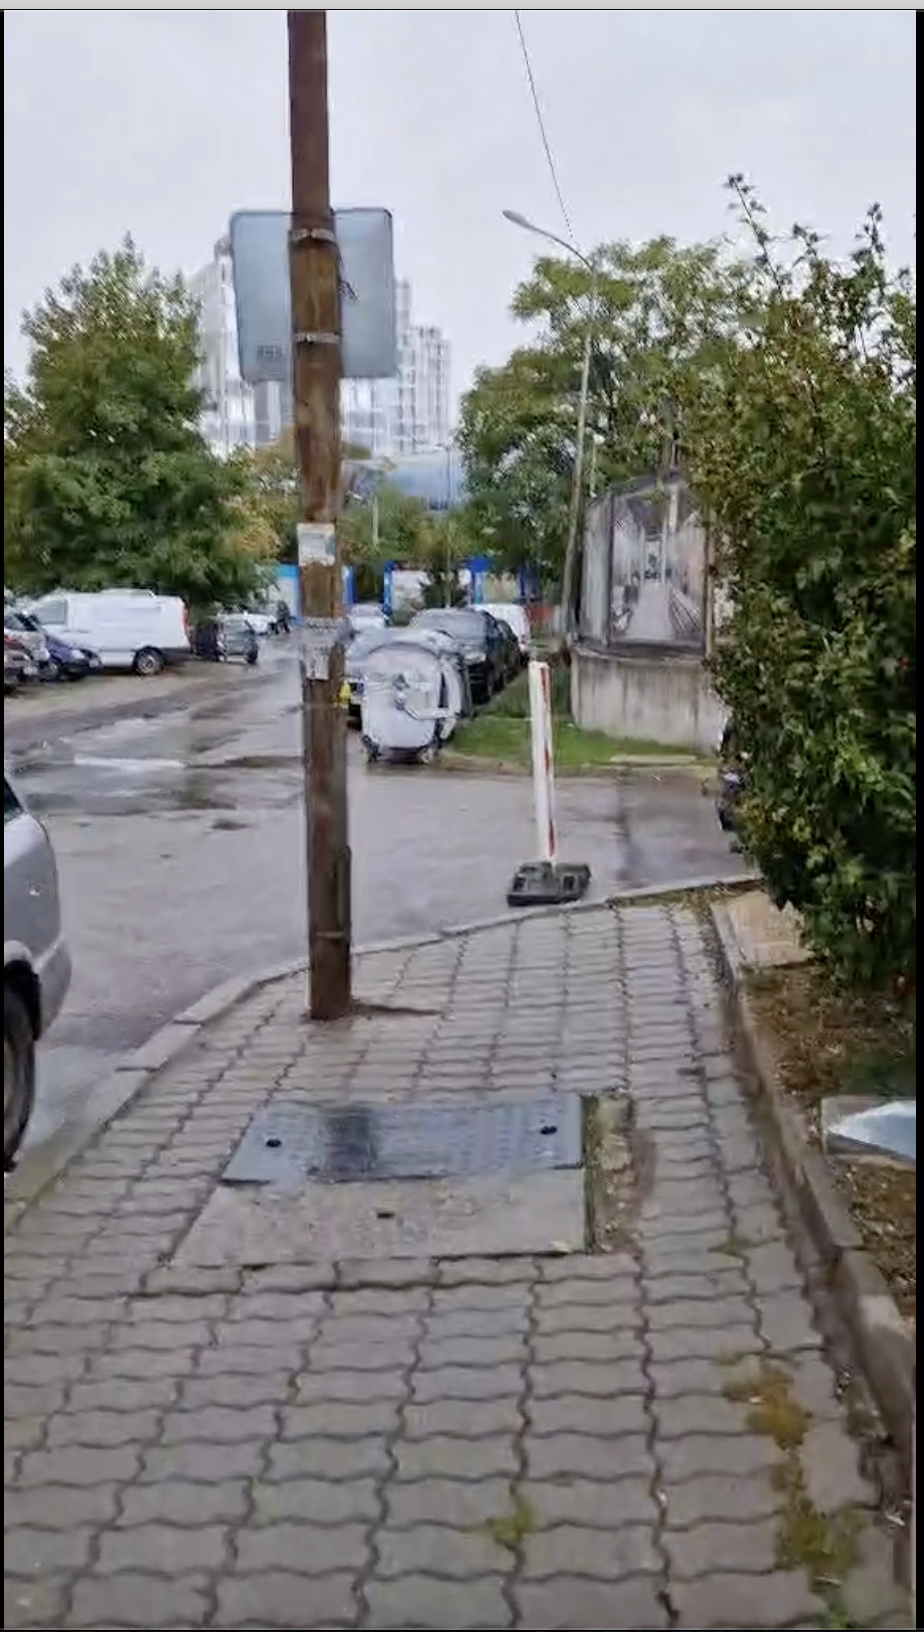

In [ ]:
import skimage
import numpy as np
from PIL import Image

image = Image.open('<image_path>')

#image = np.array(image.convert("RGB"))
#image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

In [ ]:
predictions = detector(
    image,
    candidate_labels=["bin", "rocket", "nasa badge", "star-spangled banner"],
)
predictions

In [ ]:
from PIL import Image
import requests
import io

# Base URL for raw content on GitHub
base_url = "<base_url>"

# List to store the loaded images
images = []

# Loop through the image frames
for i in range(260):  # 0 to 259, inclusive
    frame_number = str(i).zfill(4)  # Pad with zeros to make it 4 digits
    filename = f"frame_{frame_number}.jpeg"
    url = base_url + filename

    print(f"Attempting to load: {url}")

    try:
        # Fetch the image
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Open the image
        img = Image.open(io.BytesIO(response.content))
        images.append(img)
        print(f"Loaded {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {filename}: {str(e)}")
    except IOError as e:
        print(f"Error opening {filename}: {str(e)}")
    except Exception as e:
        print(f"Unexpected error loading {filename}: {str(e)}")

print(f"Total images loaded: {len(images)}")

Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0000.jpeg
Loaded frame_0000.jpeg
Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0001.jpeg
Loaded frame_0001.jpeg
Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0002.jpeg
Loaded frame_0002.jpeg
Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0003.jpeg
Loaded frame_0003.jpeg
Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0004.jpeg
Loaded frame_0004.jpeg
Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0005.jpeg
Loaded frame_0005.jpeg
Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0006.jpeg
Loaded frame_0006.jpeg
Attempting to load: https://raw.githubusercontent.com/viktor436/orama/main/resources/frame_0007.jpeg
Loaded frame_0007.jpeg
Attempti

In [ ]:
import time

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two boxes."""
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    # Calculate intersection coordinates
    x_left = max(xmin1, xmin2)
    y_top = max(ymin1, ymin2)
    x_right = min(xmax1, xmax2)
    y_bottom = min(ymax1, ymax2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No overlap

    # Calculate areas
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (xmax1 - xmin1) * (ymax1 - ymin1)
    box2_area = (xmax2 - xmin2) * (ymax2 - ymin2)

    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area  # IoU

def object_detect(image, threshold):
  from PIL import ImageDraw

  start = time.time()
  image_copy = image.copy()

  predictions = detector(
      image_copy,
      candidate_labels=["bin","pole", "pot hole", "car", "van",
                        "bus","cone","dumpster", "thrash can","sign"],
  )
   # Filter predictions by score and area
  filtered_predictions = []
  for prediction in predictions:
      box = prediction["box"]
      score = prediction["score"]
      if score > threshold:
          xmin, ymin, xmax, ymax = box.values()
          width = xmax - xmin
          height = ymax - ymin
          area = width * height  # Calculate area of the bounding box
          if area > 600:
            filtered_predictions.append(prediction)
  # Sort predictions by score in descending order
  filtered_predictions.sort(key=lambda x: x["score"], reverse=True)

 # Remove boxes that overlap more than 50% (IoU > 0.5)
  final_predictions = []
  for i, pred1 in enumerate(filtered_predictions):
      keep = True
      box1 = pred1["box"].values()  # Get box1 coordinates
      for pred2 in final_predictions:
          box2 = pred2["box"].values()  # Get box2 coordinates
          iou = calculate_iou(box1, box2)
          if iou > 0.5:
              keep = False  # If overlap is more than 50%, discard pred1
              break
      if keep:
          final_predictions.append(pred1)

  draw = ImageDraw.Draw(image_copy)

  for prediction in final_predictions:
      box = prediction["box"]
      label = prediction["label"]
      score = prediction["score"]

      xmin, ymin, xmax, ymax = box.values()
      draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
      draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

  print(f"Time: {time.time() - start}")
  return image_copy

In [ ]:
import os
# Create a directory for saving processed images
output_directory = "<path>"

os.makedirs(output_directory, exist_ok=True)  # Create directory if it doesn't exist
from transformers import pipeline

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection",device = 'cuda')
# Loop through the loaded images and perform object detection
for idx, img in enumerate(images):
    try:
        # Perform object detection (with threshold of 0.25, for example)
        processed_img = object_detect(img, 0.25)

        # Generate the filename for saving
        output_path = os.path.join(output_directory, f"frame_{str(idx).zfill(4)}.jpeg")

        # Save the processed image
        processed_img.save(output_path)
        print(f"Saved detected image to {output_path}")
    except Exception as e:
        print(f"Error processing and saving image {idx}: {str(e)}")

Time: 7.985235929489136
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0000.jpeg
Time: 8.02895712852478
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0001.jpeg
Time: 7.674952983856201
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0002.jpeg
Time: 7.706061124801636
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0003.jpeg
Time: 7.84491491317749
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0004.jpeg
Time: 7.3376853466033936
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0005.jpeg
Time: 7.967500448226929
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0006.jpeg
Time: 7.20591139793396
Saved detected image to /content/drive/MyDrive/machine_learning/object_detection_v2/frame_0007.jpeg
Time: 7.93